# Week 5 Coding Homework + Reflection 5


This notebook contains two parts:
- **Part A (Coding):** Support Vector Machines (SVM) — kernels, regularization (`C`), and RBF `gamma`, with notes on class imbalance.
- **Part B (Reflection 5):** Feedback loops & DAGs + a small simulation.


In [1]:
# === Imports & setup ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, accuracy_score, f1_score

# For DAG drawings without Graphviz dependency
import networkx as nx

# General display
pd.set_option("display.max_rows", 50)
pd.set_option("display.width", 120)
print("Libraries loaded.")


Libraries loaded.



## Part A — Week 5 Coding 

This section demonstrates:
1. Baseline SVM with different **kernels** (linear vs. RBF).
2. Effect of **`C`** (regularization strength) and **`gamma`** (RBF kernel width) on performance.
3. Handling **class imbalance** (notes + `class_weight='balanced'`).


In [4]:

def load_or_generate():
    try:
        df = pd.read_csv(CSV_PATH)
        assert TARGET_COL in df.columns, f"TARGET_COL '{TARGET_COL}' not found in CSV."
        X = df.drop(columns=[TARGET_COL]).select_dtypes(include=[np.number]).fillna(0).values
        y = df[TARGET_COL].values
        print(f"Loaded dataset from {CSV_PATH} with shape {X.shape}")
        return X, y, "real"
    except Exception as e:
        print("Falling back to synthetic classification dataset (not CKD). Reason:", e)
        # Synthetic: two classes; some overlap to be non-trivial
        rng = np.random.default_rng(42)
        n = 1200
        X1 = rng.normal(loc=[0,0], scale=[1.2,1.2], size=(n//2,2))
        X2 = rng.normal(loc=[2.0,2.5], scale=[1.0,1.0], size=(n//2,2))
        X = np.vstack([X1, X2])
        y = np.array([0]*(n//2) + [1]*(n//2))
        # Inject slight class imbalance
        keep_idx = np.where(~((y==1) & (rng.random(n) < 0.15)))[0]
        X, y = X[keep_idx], y[keep_idx]
        print("Synthetic data shape:", X.shape, "Positive rate:", y.mean().round(3))
        return X, y, "synthetic"

X, y, data_source = load_or_generate()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)
print("Train/Test sizes:", X_train.shape, X_test.shape)


Falling back to synthetic classification dataset (not CKD). Reason: [Errno 2] No such file or directory: 'ckd.csv'
Synthetic data shape: (1102, 2) Positive rate: 0.456
Train/Test sizes: (826, 2) (276, 2)


In [5]:
# === Baseline SVM: linear kernel ===
pipe_linear = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="linear", class_weight="balanced"))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores_linear = cross_val_score(pipe_linear, X_train, y_train, cv=cv, scoring="f1")
print("Linear SVM CV F1 (mean ± sd):", scores_linear.mean().round(3), "±", scores_linear.std().round(3))

pipe_linear.fit(X_train, y_train)
y_pred_lin = pipe_linear.predict(X_test)
print("\nTest report (Linear):\n", classification_report(y_test, y_pred_lin, digits=3))
print("Confusion matrix (Linear):\n", confusion_matrix(y_test, y_pred_lin))


Linear SVM CV F1 (mean ± sd): 0.913 ± 0.019

Test report (Linear):
               precision    recall  f1-score   support

           0      0.939     0.927     0.933       150
           1      0.914     0.929     0.921       126

    accuracy                          0.928       276
   macro avg      0.927     0.928     0.927       276
weighted avg      0.928     0.928     0.928       276

Confusion matrix (Linear):
 [[139  11]
 [  9 117]]


Best params (RBF): {'svm__C': 10, 'svm__gamma': 'scale'}
Best CV F1: 0.917

Test report (RBF best):
               precision    recall  f1-score   support

           0      0.945     0.920     0.932       150
           1      0.908     0.937     0.922       126

    accuracy                          0.928       276
   macro avg      0.926     0.928     0.927       276
weighted avg      0.928     0.928     0.928       276

Confusion matrix (RBF best):
 [[138  12]
 [  8 118]]


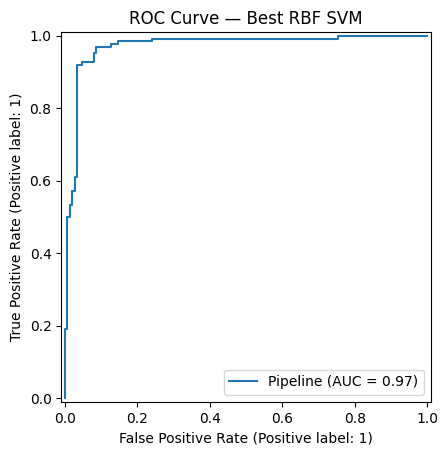

In [6]:
# === RBF SVM with grid over C and gamma ===
pipe_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", class_weight="balanced"))
])

param_grid = {
    "svm__C": [0.1, 1, 10, 100],
    "svm__gamma": ["scale", 0.1, 0.01, 0.001]
}

grid = GridSearchCV(pipe_rbf, param_grid=param_grid, cv=cv, scoring="f1", n_jobs=None)
grid.fit(X_train, y_train)
print("Best params (RBF):", grid.best_params_)
print("Best CV F1:", round(grid.best_score_, 3))

best_rbf = grid.best_estimator_
y_pred_rbf = best_rbf.predict(X_test)
print("\nTest report (RBF best):\n", classification_report(y_test, y_pred_rbf, digits=3))
print("Confusion matrix (RBF best):\n", confusion_matrix(y_test, y_pred_rbf))

# Single ROC curve display (binary)
try:
    RocCurveDisplay.from_estimator(best_rbf, X_test, y_test)
    plt.title("ROC Curve — Best RBF SVM")
    plt.show()
except Exception as e:
    print("ROC plot skipped:", e)



### Conclusions (edit these after you run)
- **Best kernel:** (Fill: linear vs RBF) — compare CV F1 means and test reports.
- **Effect of `C`:** Higher `C` usually fits harder (lower regularization), can improve training but risk overfit.
- **Effect of `gamma` (RBF):** Larger `gamma` makes decision boundary more wiggly (local); too large can overfit.
- **Class imbalance:** We used `class_weight='balanced'`. You can also try resampling (SMOTE) or threshold tuning.



## Part B — Reflection 5: Feedback Loops & DAGs
We'll draw DAGs with **networkx** and **matplotlib** (no Graphviz dependency) and build the requested simulation.



### Q1. Negative Feedback Loop
High **Body Temperature (T)** increases **Sweating (S)**; **Sweating** increases **Cooling (C)**; **Cooling** **reduces** **Body Temperature**.


In [14]:
# Body Temp (T_t) --(+)-> Sweating (S_t) --(+)-> Cooling (C_t) --(-)-> Body Temp (T_{t+1})

diagram = """
Body Temp (T_t) --(+)-> Sweating (S_t) --(+)-> Cooling (C_t) --(-)-> Body Temp (T_{t+1})
"""
print(diagram)



Body Temp (T_t) --(+)-> Sweating (S_t) --(+)-> Cooling (C_t) --(-)-> Body Temp (T_{t+1})



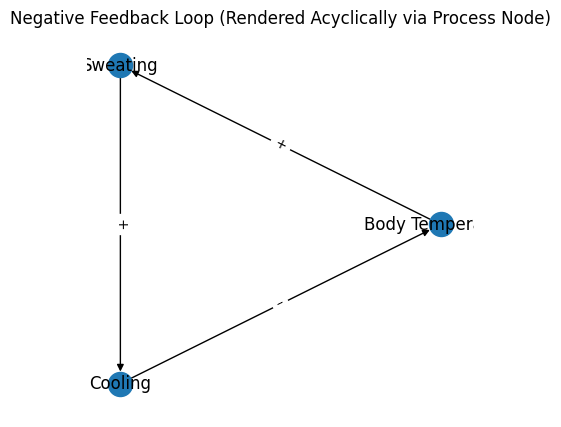

In [7]:
# === Draw DAG for negative feedback using networkx ===
G = nx.DiGraph()
G.add_nodes_from([("T", {"label":"Body Temperature"}),
                  ("S", {"label":"Sweating"}),
                  ("C", {"label":"Cooling"})])

G.add_edges_from([("T","S"), ("S","C"), ("C","T")])

pos = nx.circular_layout(G)

plt.figure(figsize=(5,5))
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G, pos, labels={n:d["label"] for n,d in G.nodes(data=True)})
nx.draw_networkx_edges(G, pos, arrows=True)

# Edge labels with signs
edge_labels = {("T","S"): "+", ("S","C"): "+", ("C","T"): "–"}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.axis("off")
plt.title("Negative Feedback Loop (Rendered Acyclically via Process Node)")
plt.show()



### Q2. Positive Feedback Loop (example)
Example: **Social Media Use (U)** and **Anxiety (A)** can amplify each other. To keep the diagram DAG-compliant, we can add a time-step or mediator (e.g., **Rumination (R)**):  
`U → A → R → U`. Signs are positive on each edge.


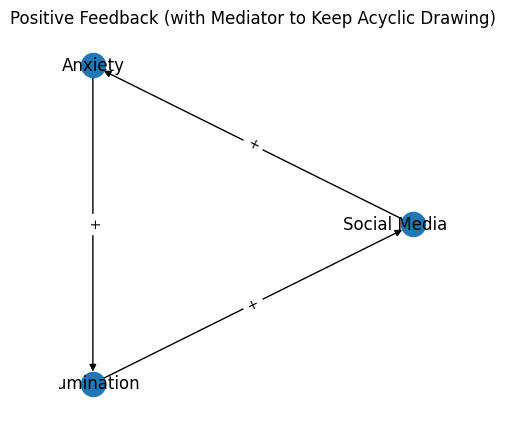

In [8]:
# === Draw a positive feedback example as a DAG with a mediator ===
G2 = nx.DiGraph()
G2.add_nodes_from([("U", {"label":"Social Media Use"}),
                   ("A", {"label":"Anxiety"}),
                   ("R", {"label":"Rumination"})])
G2.add_edges_from([("U","A"), ("A","R"), ("R","U")])

pos2 = nx.circular_layout(G2)

plt.figure(figsize=(5,5))
nx.draw_networkx_nodes(G2, pos2)
nx.draw_networkx_labels(G2, pos2, labels={n:d["label"] for n,d in G2.nodes(data=True)})
nx.draw_networkx_edges(G2, pos2, arrows=True)
nx.draw_networkx_edge_labels(G2, pos2, edge_labels={("U","A"): "+", ("A","R"): "+", ("R","U"): "+"})
plt.axis("off")
plt.title("Positive Feedback (with Mediator to Keep Acyclic Drawing)")
plt.show()



### Q3. Lightning–Deer–Bears–Flowers
**DAG relations:** Lightning frightens away deer and bears (reduces both) and increases flowers; bears eat deer (reduces deer); deer eat flowers (reduces flowers).  
We'll simulate data with noise and show a backdoor path (Lightning confounds Deer–Flowers).


In [10]:
# === Simulation for Q3 ===
np.random.seed(42)
n = 5000

lightning = np.random.uniform(0, 1, n)
bears = np.maximum(1 - lightning + np.random.normal(0, 0.2, n), 0)
deer = np.maximum(1 - (0.5*bears + 0.7*lightning) + np.random.normal(0, 0.2, n), 0)
flowers = np.minimum(lightning + np.random.normal(0, 0.2, n) - 0.4*deer, 1)

df_sim = pd.DataFrame({'lightning': lightning, 'bears': bears, 'deer': deer, 'flowers': flowers})
df_sim.describe().T


,count,mean,std,min,25%,50%,75%,max
lightning,5000.0,0.496832,0.289634,0.000012,0.243863,0.500009,0.748101,0.999718
bears,5000.0,0.511162,0.337935,0.000000,0.242249,0.499737,0.766817,1.549630
deer,5000.0,0.401223,0.220979,0.000000,0.243759,0.396059,0.553409,1.222041
flowers,5000.0,0.335746,0.373413,-0.752172,0.048981,0.343179,0.625526,1.000000


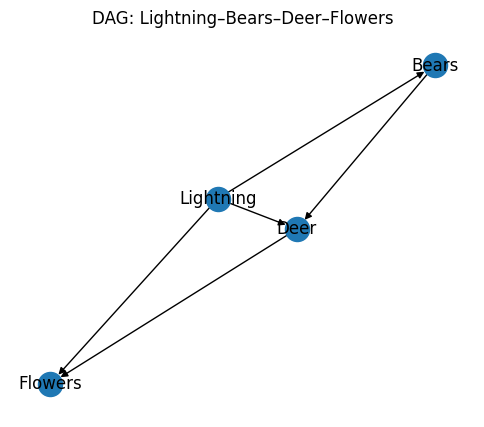

In [11]:
# === DAG drawing for Q3 ===
G3 = nx.DiGraph()
labels3 = {
    "L": "Lightning",
    "B": "Bears",
    "D": "Deer",
    "F": "Flowers"
}
G3.add_nodes_from([(k, {"label": v}) for k,v in labels3.items()])
G3.add_edges_from([("L","B"), ("L","D"), ("L","F"),
                   ("B","D"),
                   ("D","F")])

pos3 = nx.spring_layout(G3, seed=3)
plt.figure(figsize=(6,5))
nx.draw_networkx_nodes(G3, pos3)
nx.draw_networkx_labels(G3, pos3, labels={n:d["label"] for n,d in G3.nodes(data=True)})
nx.draw_networkx_edges(G3, pos3, arrows=True)
plt.axis("off")
plt.title("DAG: Lightning–Bears–Deer–Flowers")
plt.show()



**Backdoor path (Deer → Flowers):** Lightning is a **confounder** because it affects both deer and flowers. The backdoor path is `Deer ← Lightning → Flowers`. Controlling for lightning blocks this path when estimating the effect of deer on flowers.



### Q4. Original DAG with Confounder and Collider
**Nodes:** Education (X), Income (Y), Parental Support (C), Work Stress (W), Personality (P).  
**Edges:** C → X, C → Y, X → Y, X → W, P → W.  
- **Treatment-like (X):** Education  
- **Outcome-like (Y):** Income  
- **Confounder:** Parental Support (C)  
- **Collider:** Work Stress (W) (has incoming arrows from X and P)


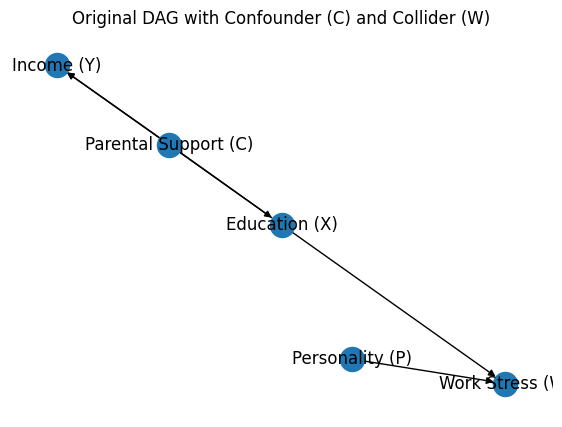

In [12]:
# === DAG drawing for Q4 ===
G4 = nx.DiGraph()
labels4 = {"X":"Education (X)", "Y":"Income (Y)", "C":"Parental Support (C)", "W":"Work Stress (W)", "P":"Personality (P)"}
G4.add_nodes_from([(k, {"label": v}) for k,v in labels4.items()])

G4.add_edges_from([("C","X"), ("C","Y"), ("X","Y"), ("X","W"), ("P","W")])

pos4 = nx.spring_layout(G4, seed=7)
plt.figure(figsize=(7,5))
nx.draw_networkx_nodes(G4, pos4)
nx.draw_networkx_labels(G4, pos4, labels={n:d["label"] for n,d in G4.nodes(data=True)})
nx.draw_networkx_edges(G4, pos4, arrows=True)
plt.axis("off")
plt.title("Original DAG with Confounder (C) and Collider (W)")
plt.show()
